# Atividade 5

Planejamento de Sistemas Elétricos - PPEE

Aluno: Alexandre Soares Altgott

Matrícula: 102100645

In [ ]:
!pip install PySDDP

In [1]:
from google.colab import drive, files
import os

#Montar o Google Drive no Colab com o nome gdrive

drive.mount('/content/gdrive')

# O comando abaixo mostra qual diretório você está trabalhando momento.
print( os.getcwd() )

Caminho_do_Arquivo = 'gdrive/My Drive/NewaveJuly2023/'
# O comando mostra o que está presente dentro da minha pasta GIF no meu drive, que está dentro do meu drive e em Doutorado. Mudar para o diretório que vocês criaram.
print( os.listdir(Caminho_do_Arquivo) )

['ADTERM.DAT', 'AGRINT.DAT', 'ARQUIVOS.DAT', 'BID.DAT', 'CASO.DAT', 'CDEFVAR.DAT', 'CLAST.DAT', 'CONFHD.DAT', 'CONFT.DAT', 'CURVA.DAT', 'CVAR.DAT', 'C_ADIC.DAT', 'DGER.DAT', 'DSVAGUA.DAT', 'ELNINO.DAT', 'ENSOAUX.DAT', 'EXPH.DAT', 'EXPT.DAT', 'FORMAT.TMP', 'GHMIN.DAT', 'GTMINPAT.DAT', 'GTMIN_CCEE_072023.xlsx', 'HIDR.DAT', 'ITAIPU.DAT', 'LOSS.DAT', 'MANUTT.DAT', 'MENSAG.TMP', 'MODIF.DAT', 'NewaveMsgPortug.txt', 'PATAMAR.DAT', 'PENALID.DAT', 'POSTOS.DAT', 'RE.DAT', 'REE.DAT', 'selcor.dat', 'SHIST.DAT', 'SISTEMA.DAT', 'tecno.dat', 'TERM.DAT', 'VAZOES.DAT', 'VAZPAST.DAT']


In [2]:
from PySDDP.Pen import Newave

PMOSET2023 = Newave(Caminho_do_Arquivo)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


In [144]:
Usina = PMOSET2023.confhd.get('Furnas')

## Modelo de Otimização para o Problema Analisado

Para o caso exemplo do mês de agosto a ser estimado a vazão

$Min \hspace{0.5cm} \varepsilon_{ago,1931}^2 + \varepsilon_{ago,1932}^2  + ... + \varepsilon_{ago,2020}^2  + \varepsilon_{ago,2021}^2  $

Sujeito a:

$Z_{ago,1932} = \phi_1 \cdot Z_{jul,1932} + \phi_2 \cdot Z_{jun,1932} + ... +  \phi_n \cdot Z_{n,1932}  + \varepsilon_{mar,1932}^2  $

$Z_{ago,1933} = \phi_1 \cdot Z_{jul,1933} + \phi_2 \cdot Z_{jun,1933} + ... +  \phi_n \cdot Z_{n,1933}  + \varepsilon_{mar,1933}^2  $

.

.

.

$Z_{ago,2021} = \phi_1 \cdot Z_{jul,2021} + \phi_2 \cdot Z_{jun,2021} + ... +  \phi_n \cdot Z_{n,2021}  + \varepsilon_{mar,2021}^2  $

## Função do Modelo Auto-Regressivo

In [49]:
from cvxopt import matrix, solvers
import numpy as np


def Series_Sinteticas(Usina, AnoAnalisado, N_meses, Mes_analisado,imprime = False):
    """
    Função que calcula a série sintética de vazões de uma usina
    """


    # Retira o ultimo e o primeiro ano e considera que a contagem começa em zero
    N_anos = len(Usina['vazoes']) - 3

    AnoAnalisado = AnoAnalisado - 2023 + N_anos + 2

    if Mes_analisado - N_meses >= 0:

        recorte = Usina['vazoes'][1:N_anos+1,(Mes_analisado-N_meses):Mes_analisado]

    else:

        recorteAnoAtual = Usina['vazoes'][1:N_anos+1,0:Mes_analisado]

        recorteAnoAnt = Usina['vazoes'][0:N_anos,(Mes_analisado-N_meses):]

        recorte = np.hstack((recorteAnoAnt,recorteAnoAtual))

    
    identidade = np.eye(N_anos)

    Aeq = np.concatenate((recorte, identidade), axis = 1)
    Aeq = Aeq.astype('float')
    Aeq = matrix(Aeq)

    Beq = Usina['vazoes'][1:N_anos+1,Mes_analisado]
    Beq = Beq.astype('float')
    Beq = matrix(Beq)
    q = matrix(np.zeros(N_anos+N_meses))
    P = 2*np.eye(N_anos+N_meses)
    for i in range(0,N_meses):
        P[i][i] = 0
    P = matrix(P)




    A = np.vstack((-1*np.eye(N_anos+N_meses), np.eye(N_anos+N_meses)))
    A = A.astype('float')
    A = matrix(A)
    B = 99999*np.ones(((N_anos+N_meses)*2,1))

    B = B.astype('float')
    B = matrix(B)


    solvers.options['show_progress'] = False
    abstol = 1e-9
    reltol = 1e-9
    sol = solvers.qp(P, q, A, B, Aeq, Beq, abstol=abstol, reltol=reltol)

    fob = sum(sol['x'][N_meses:])

    if Mes_analisado - N_meses >= 0:
        
        soma = 0

        for i, v in enumerate(Usina['vazoes'][AnoAnalisado,(Mes_analisado-N_meses):Mes_analisado]):
            
            soma += v*sol['x'][i]

    else:

        soma = 0

        for i, v in enumerate(Usina['vazoes'][AnoAnalisado,0:Mes_analisado]):

            soma += v*sol['x'][i+N_meses-Mes_analisado]

        for i, v in enumerate(Usina['vazoes'][AnoAnalisado-1,(Mes_analisado-N_meses):]):

            soma += v*sol['x'][i]

    if imprime:

        print(f'Vazão estimada para o mês {Mes_analisado}: {soma} hm^3')

    return [fob,soma,sol['x']]




    
        


## Programa Principal

A vazão estimada para o mês 4, considerando os 3 últimos meses para o cálculo, é de: 1063.0034590229627 m³/s


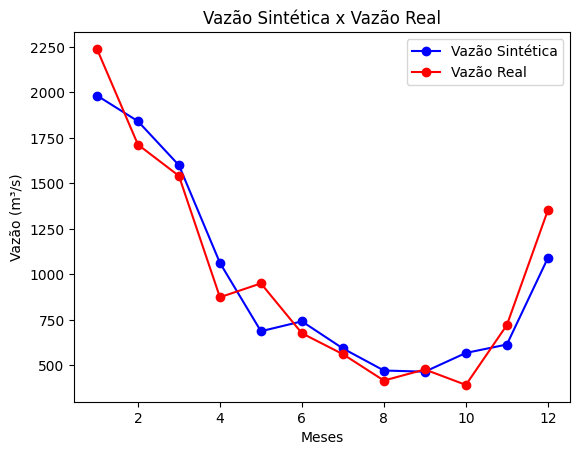

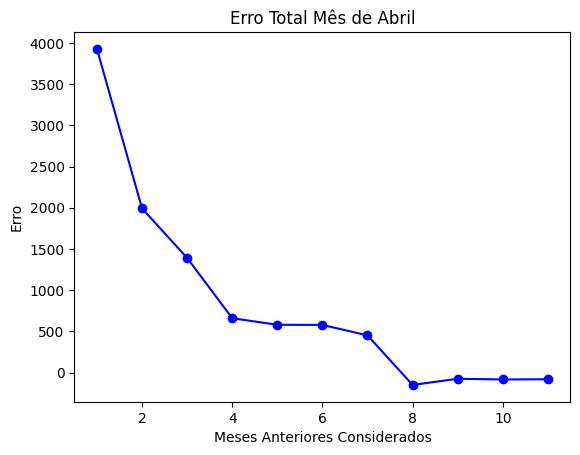

In [153]:
from cvxopt import matrix, solvers
from matplotlib import pyplot as plt



# Ano a ser analisado
AnoAnalisado = 2021

# Numero de meses anteriores a serem considerados
N_meses = 3

# Retira o ultimo e o primeiro ano e considera que a contagem começa em zero
N_anos = len(Usina['vazoes']) - 3

# Numero do mes considerando janeiro zero
Mes_analisado = 7

# Excluir anos mais recentes caso queira
# Usina['vazoes'] = Usina['vazoes'][:-2]


print(f'A vazão estimada para o mês {Mes_analisado + 1}, considerando os {N_meses} últimos meses para o cálculo, é de: {Series_Sinteticas(Usina, AnoAnalisado, N_meses, Mes_analisado)[1]} m³/s')

resultado = []
fob = []

for i in range(0,12):

    resposta = Series_Sinteticas(Usina, AnoAnalisado, N_meses, i)
    resultado.append(resposta[1])


for i in range(1,12):

    resposta = Series_Sinteticas(Usina, AnoAnalisado, i, Mes_analisado)
    fob.append(resposta[0])

    

# Converte o ano para o indice da lista
AnoAnalisado = AnoAnalisado - 2023 + N_anos + 2



plt.figure()
plt.title("Vazão Sintética x Vazão Real")
plt.xlabel("Meses")
plt.ylabel("Vazão (m³/s)")
plt.plot(list(range(1,13)),resultado,marker="o",color="blue",label="Vazão Sintética")
plt.plot(list(range(1,13)),Usina['vazoes'][AnoAnalisado],marker="o",color="red",label="Vazão Real")
plt.legend()


plt.figure()
plt.title("Erro Total Mês de Abril")
plt.xlabel("Meses Anteriores Considerados")
plt.ylabel("Erro")
plt.plot(list(range(1,12)),fob,marker="o",color="blue")



## Plot do Erro por Meses Anteriores Vistos e Mês Analisado

Aqui é plotado o erro ao se variar o mês analisado (de janeiro a dezembro) e quantos meses anteriores (de 1 a 12) se olha para mostrar se há meses com estimações mais erroneas e como a quantidades de meses anteriores que se considera impactam no erro. 

Como mostra o gráfico, os meses do meio do ano possuem um erro menor, assim como ao se olhar para mais meses anteriores há um tendência de melhores resultados.

Text(0.5, 0.92, 'Erro por Meses Anteriores Vistos e Mês Analisado')

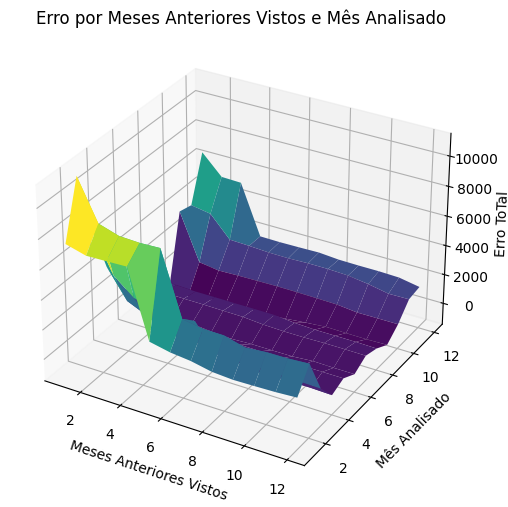

In [152]:
size = 12
default_value = []
AnoAnalisado = 2020

resultado = []
resultado.extend([default_value] * size)
for i in range(0,12):
    resultado[i] = []
    resultado[i].extend([default_value] * 12)


for i in range(0,12):
    for j in range(1,13):
        resposta = Series_Sinteticas(Usina, AnoAnalisado, j, i)
        resultado[i][j-1] = resposta[0]

x = np.linspace(1, 12, 12)
y = np.linspace(1, 12, 12)
x, y = np.meshgrid(x, y)

resultado = np.array(resultado)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar a superfície
surf = ax.plot_surface(x, y, resultado, cmap='viridis')

ax.set_xlabel('Meses Anteriores Vistos')
ax.set_ylabel('Mês Analisado')
ax.set_zlabel('Erro ToTal')
plt.title('Erro por Meses Anteriores Vistos e Mês Analisado')